<a href="https://colab.research.google.com/github/Siahkamari/Piecewise-linear-regression/blob/master/Python/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Siahkamari/Piecewise-linear-regression.git
%cd /content/Piecewise-linear-regression/Python

Cloning into 'Piecewise-linear-regression'...
remote: Enumerating objects: 465, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (395/395), done.
remote: Total 465 (delta 164), reused 265 (delta 65), pack-reused 0
Receiving objects: 100% (465/465), 22.97 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (164/164), done.
/content/Piecewise-linear-regression/Python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Lets download the airfoil data from UCI repository

In [3]:
import urllib.request
print('Downloading data')
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
urllib.request.urlretrieve(url, 'airfoil_self_noise.csv')

('airfoil_self_noise.csv', <http.client.HTTPMessage at 0x7f7b861a1410>)

## Read the data in numpy format (.npy)

In [4]:
col_names = ['Frequency','Angle of attack','Chord length','Velocity','Thickness','Sound pressure']
df = pd.read_csv('airfoil_self_noise.csv',delimiter='\t',names=col_names)
df.head()

Frequency  Angle of attack  ...  Thickness  Sound pressure
0        800              0.0  ...   0.002663         126.201
1       1000              0.0  ...   0.002663         125.201
2       1250              0.0  ...   0.002663         125.951
3       1600              0.0  ...   0.002663         127.591
4       2000              0.0  ...   0.002663         127.461

[5 rows x 6 columns]

## Split the data to training and test

In [12]:
y = df["Sound pressure"].to_numpy()
X = df.drop("Sound pressure",axis = 1).to_numpy()
n = len(y)

rng = np.random.default_rng(0)
I= rng.permutation(n)
X = X[I]
y = y[I]

mu = np.mean(X,axis=0)
X = (X-mu)/np.max(np.abs(X),axis=0)
y = y/np.max(np.abs(y))

X_train = X[0:np.int(4/5*n)]
y_train = y[0:np.int(4/5*n)]

X_test = X[np.int(4/5*n):]
y_test = y[np.int(4/5*n):]

## Baseline Models (LLR and XGBOOST)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

model1 = RidgeCV()

xgb_params = {'max_depth': [1, 2, 3 ,4 , 5, 6, 7, 8, 9, 10],
              'learning_rate': [0.01, 0.05, .1, 0.5]}
xgb = XGBRegressor(objective="reg:squarederror", seed = 0)
model2 = GridSearchCV(estimator=xgb,
                      param_grid=xgb_params)


for model in [model1, model2]:
  # Fitting
  model.fit(X_train, y_train)

  # Testting
  train_loss = model.score(X_train, y_train)
  test_loss = model.score(X_test, y_test)
  print("~~~~~~~~~~~~~~~~~~~~~~~~")
  print("Train R^2 = ", round(train_loss,2))
  print("Test R^2 = ", round(test_loss,2))


~~~~~~~~~~~~~~~~~~~~~~~~
Train R^2 =  0.52
Test R^2 =  0.5
~~~~~~~~~~~~~~~~~~~~~~~~
Train R^2 =  1.0
Test R^2 =  0.96


## DC regression

In [7]:
import torch as th
from piecewise_linear_estimation import  dc_regression
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

X_train = th.from_numpy(X_train.astype('float64')).to(device)
y_train = th.from_numpy(y_train.astype('float64')).to(device)  
X_test = th.from_numpy(X_test.astype('float64')).to(device)
y_test = th.from_numpy(y_test.astype('float64')).to(device)   

model = dc_regression()
# Fitting
model.fit(X_train, y_train)

# Testting
train_loss = model.score(X_train, y_train).item()
test_loss = model.score(X_test, y_test).item()
print("\n~~~~~~~~~~~~~~~~~~~~~~~~")
print("Train R^2 = ", round(train_loss,2))
print("Test R^2 = ", round(test_loss,2))


Search for lanbda:   0%|          | 0/7 [00:00<?, ?it/s]

lanbda =  3.47e+04 , n_iter = 961 , training score =  0.001 , validation score =  -0.002
lanbda =  3.47e+03 , n_iter = 961 , training score =  0.001 , validation score =  -0.002
lanbda =  3.47e+02 , n_iter = 961 , training score =  0.001 , validation score =  -0.002
lanbda =  3.47e+01 , n_iter = 961 , training score =  0.001 , validation score =  -0.002
lanbda =  3.47e+00 , n_iter = 961 , training score =  0.378 , validation score =  0.372
lanbda =  3.47e-01 , n_iter = 2692 , training score =  0.837 , validation score =  0.810
lanbda =  3.47e-02 , n_iter = 6539 , training score =  0.966 , validation score =  0.922


Search for lanbda:   0%|          | 0/4 [00:00<?, ?it/s]

lanbda =  3.47e-02 , n_iter = 6539 , training score =  0.966 , validation score =  0.922
lanbda =  3.47e-03 , n_iter = 6346 , training score =  0.988 , validation score =  0.939
lanbda =  3.47e-04 , n_iter = 7115 , training score =  0.992 , validation score =  0.942
lanbda =  3.47e-05 , n_iter = 6731 , training score =  0.992 , validation score =  0.942


Search for lanbda:   0%|          | 0/5 [00:00<?, ?it/s]

lanbda =  1.39e-03 , n_iter = 6923 , training score =  0.991 , validation score =  0.942
lanbda =  6.93e-04 , n_iter = 7115 , training score =  0.992 , validation score =  0.943
lanbda =  3.47e-04 , n_iter = 7115 , training score =  0.992 , validation score =  0.942
lanbda =  1.73e-04 , n_iter = 7116 , training score =  0.992 , validation score =  0.943
lanbda =  8.67e-05 , n_iter = 6731 , training score =  0.992 , validation score =  0.942

~~~~~~~~~~~~~~~~~~~~~~~~
Train R^2 =  0.99
Test R^2 =  0.95


## Surf plot of estimators in 2 dimmensions

In [8]:
def plotxxy(model, X, y, device):
  import matplotlib.pyplot as plt
  from matplotlib import cm
  from mpl_toolkits.mplot3d import Axes3D

  dim = X.shape[1]
  plt.rcParams['figure.figsize'] = [24, 16]
  plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

  fig = plt.figure()
  ax = fig.gca(projection='3d')

  d_mesh = 0.01
  X_mesh = np.arange(np.min(X[:,0]), np.max(X[:,0]), d_mesh)
  Y_mesh = np.arange(np.min(X[:,1]), np.max(X[:,1]), d_mesh)
  X_mesh, Y_mesh = np.meshgrid(X_mesh, Y_mesh)

  X_mesh_all = np.concatenate((X_mesh.reshape(-1,1),Y_mesh.reshape(-1,1)), axis=1)
  if dim > 2:
      X_mesh_all = np.concatenate((X_mesh_all, np.zeros([X_mesh_all.shape[0], dim-2])), axis=1)

  if device == 'cuda':
    X_mesh_all_g = th.from_numpy(X_mesh_all.astype('float64')).to(device)
    f_hat_mesh = model.predict(X_mesh_all_g).reshape(X_mesh.shape).cpu().numpy()
  else:
    f_hat_mesh = model.predict(X_mesh_all).reshape(X_mesh.shape)

  # Plot the surface.
  surf = ax.plot_surface(X_mesh, Y_mesh, f_hat_mesh, cmap = cm.coolwarm)
  ax.scatter(X[:,0],X[:,1],y)

  ax.set_xlabel('X_1')
  ax.set_ylabel('X_2')
  ax.set_zlabel('y')

  # Turn off tick labels
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  ax.set_zticklabels([])

  plt.show()

XGBoost model on first 2 features


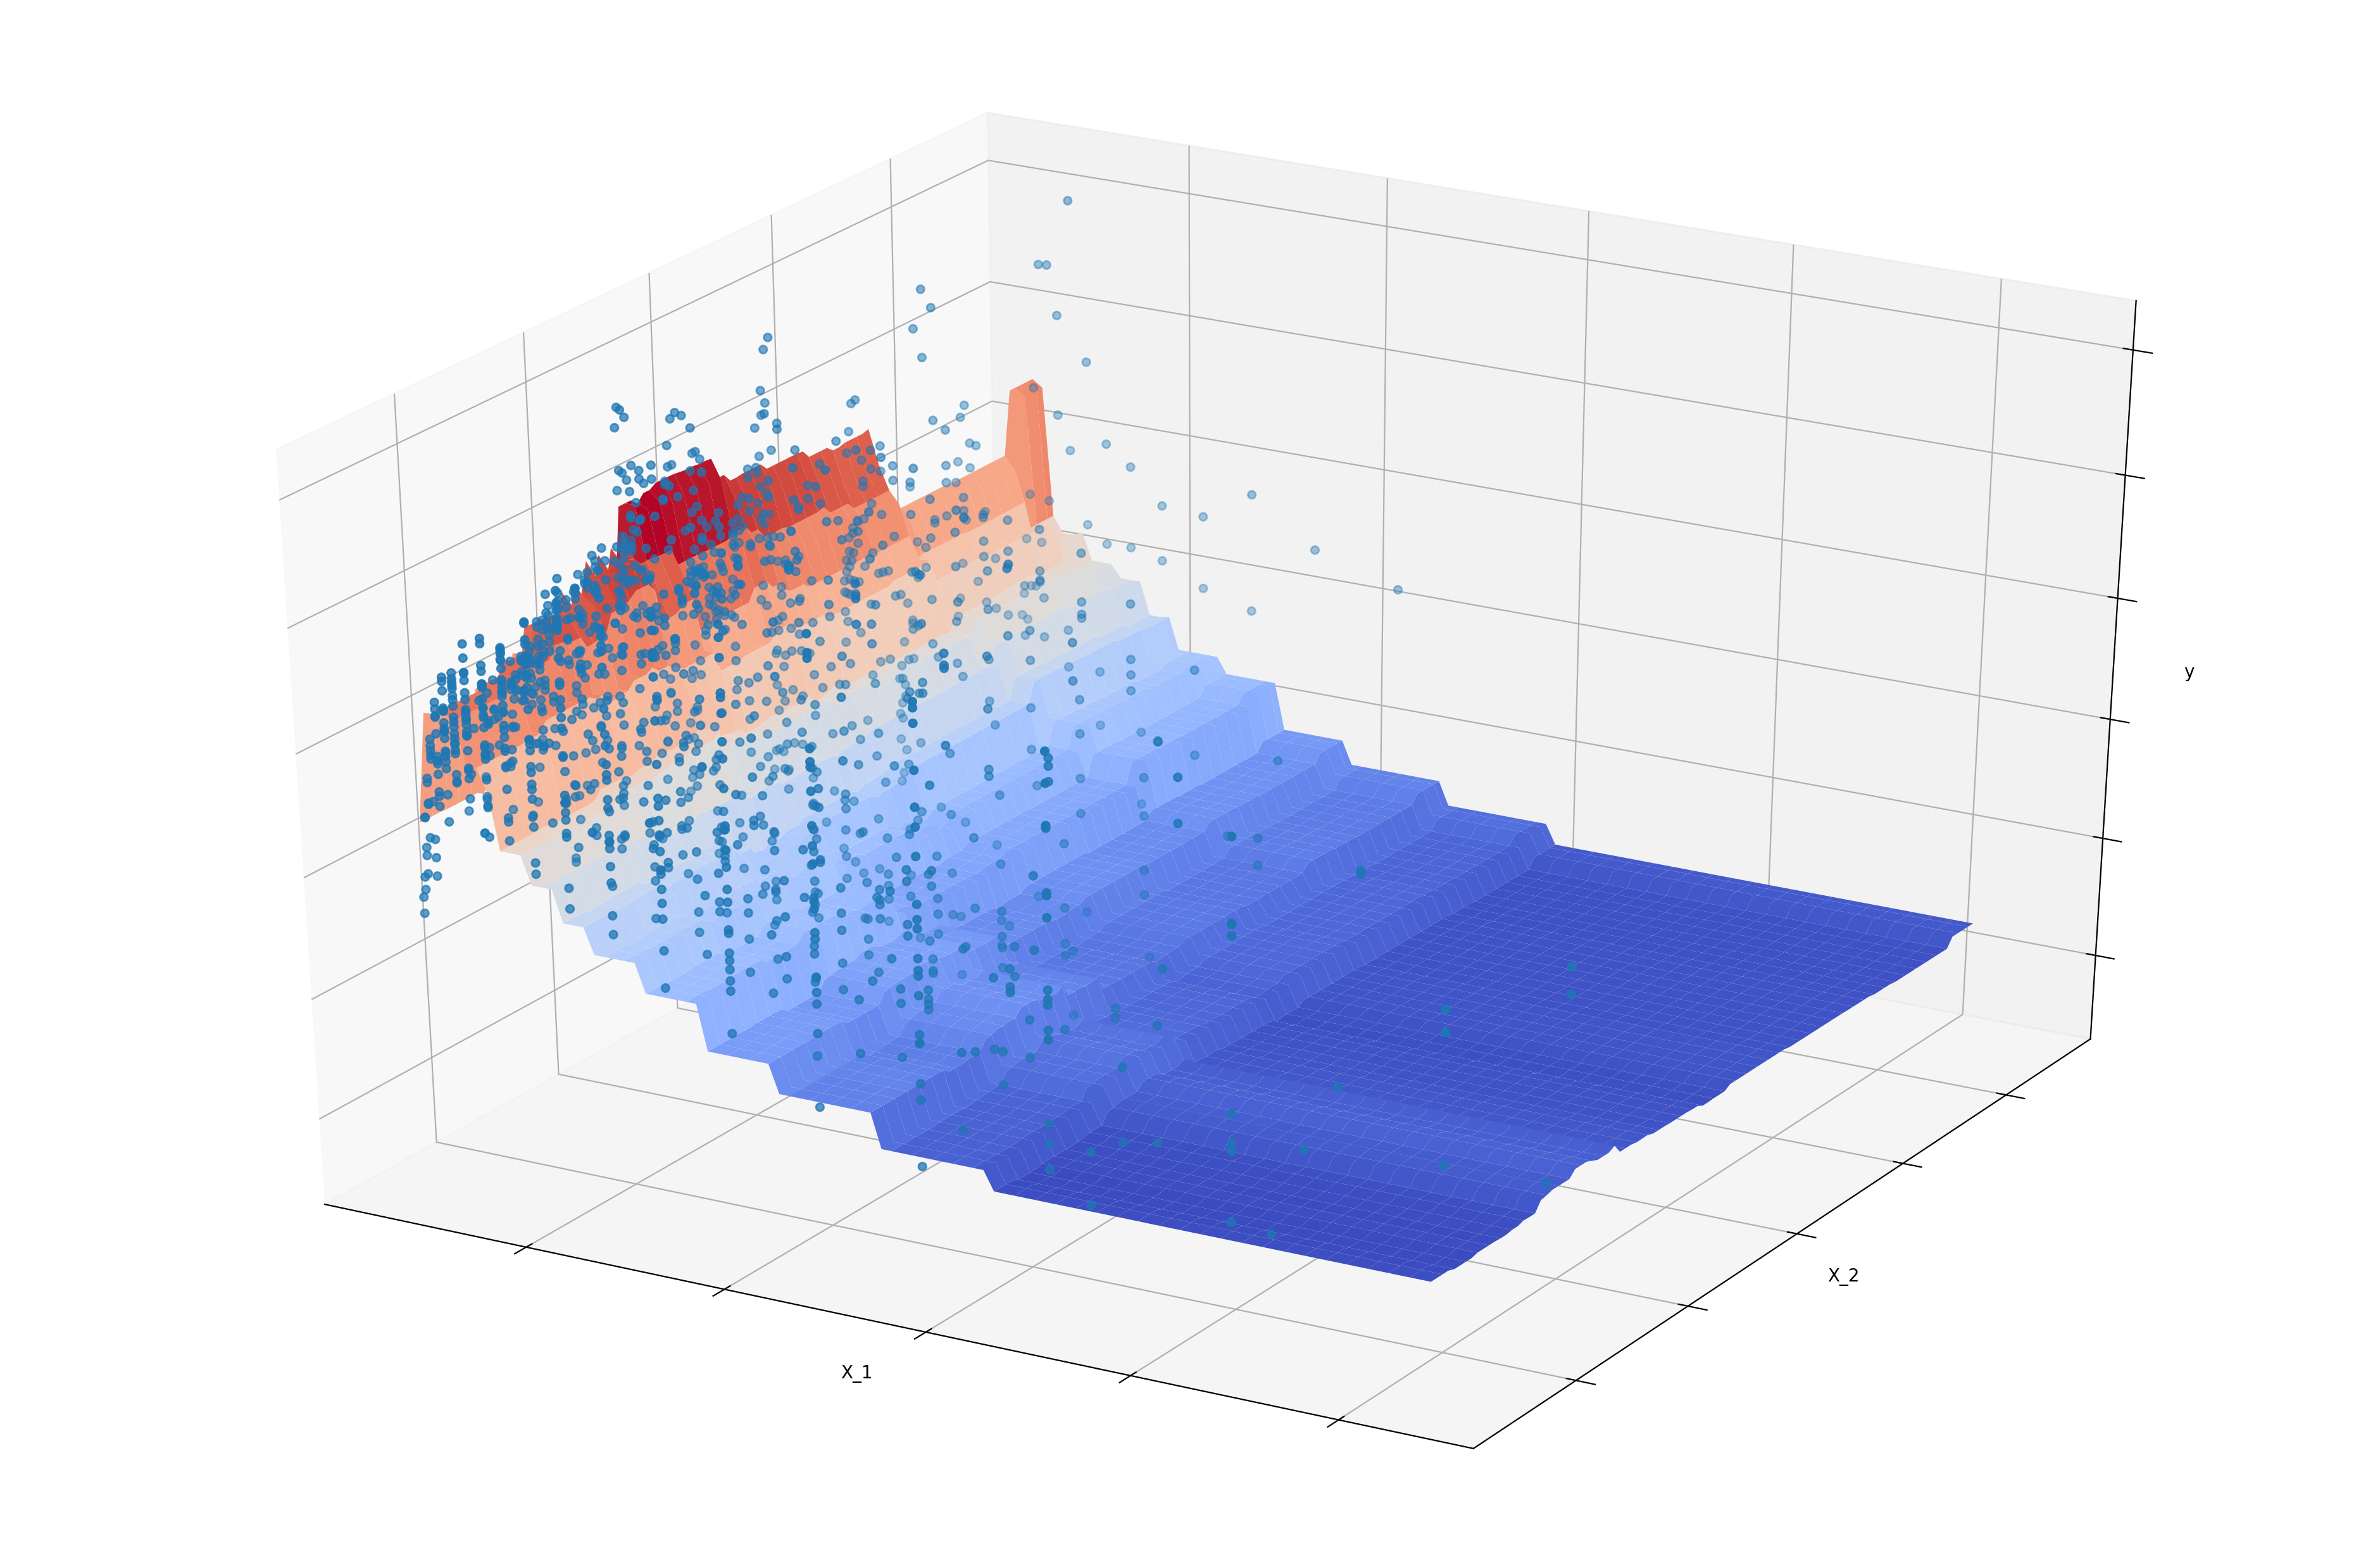

In [14]:
print("XGBoost model on first 2 features")
plotxxy(model2, X, y, 'cpu')

DC model on first 2 features


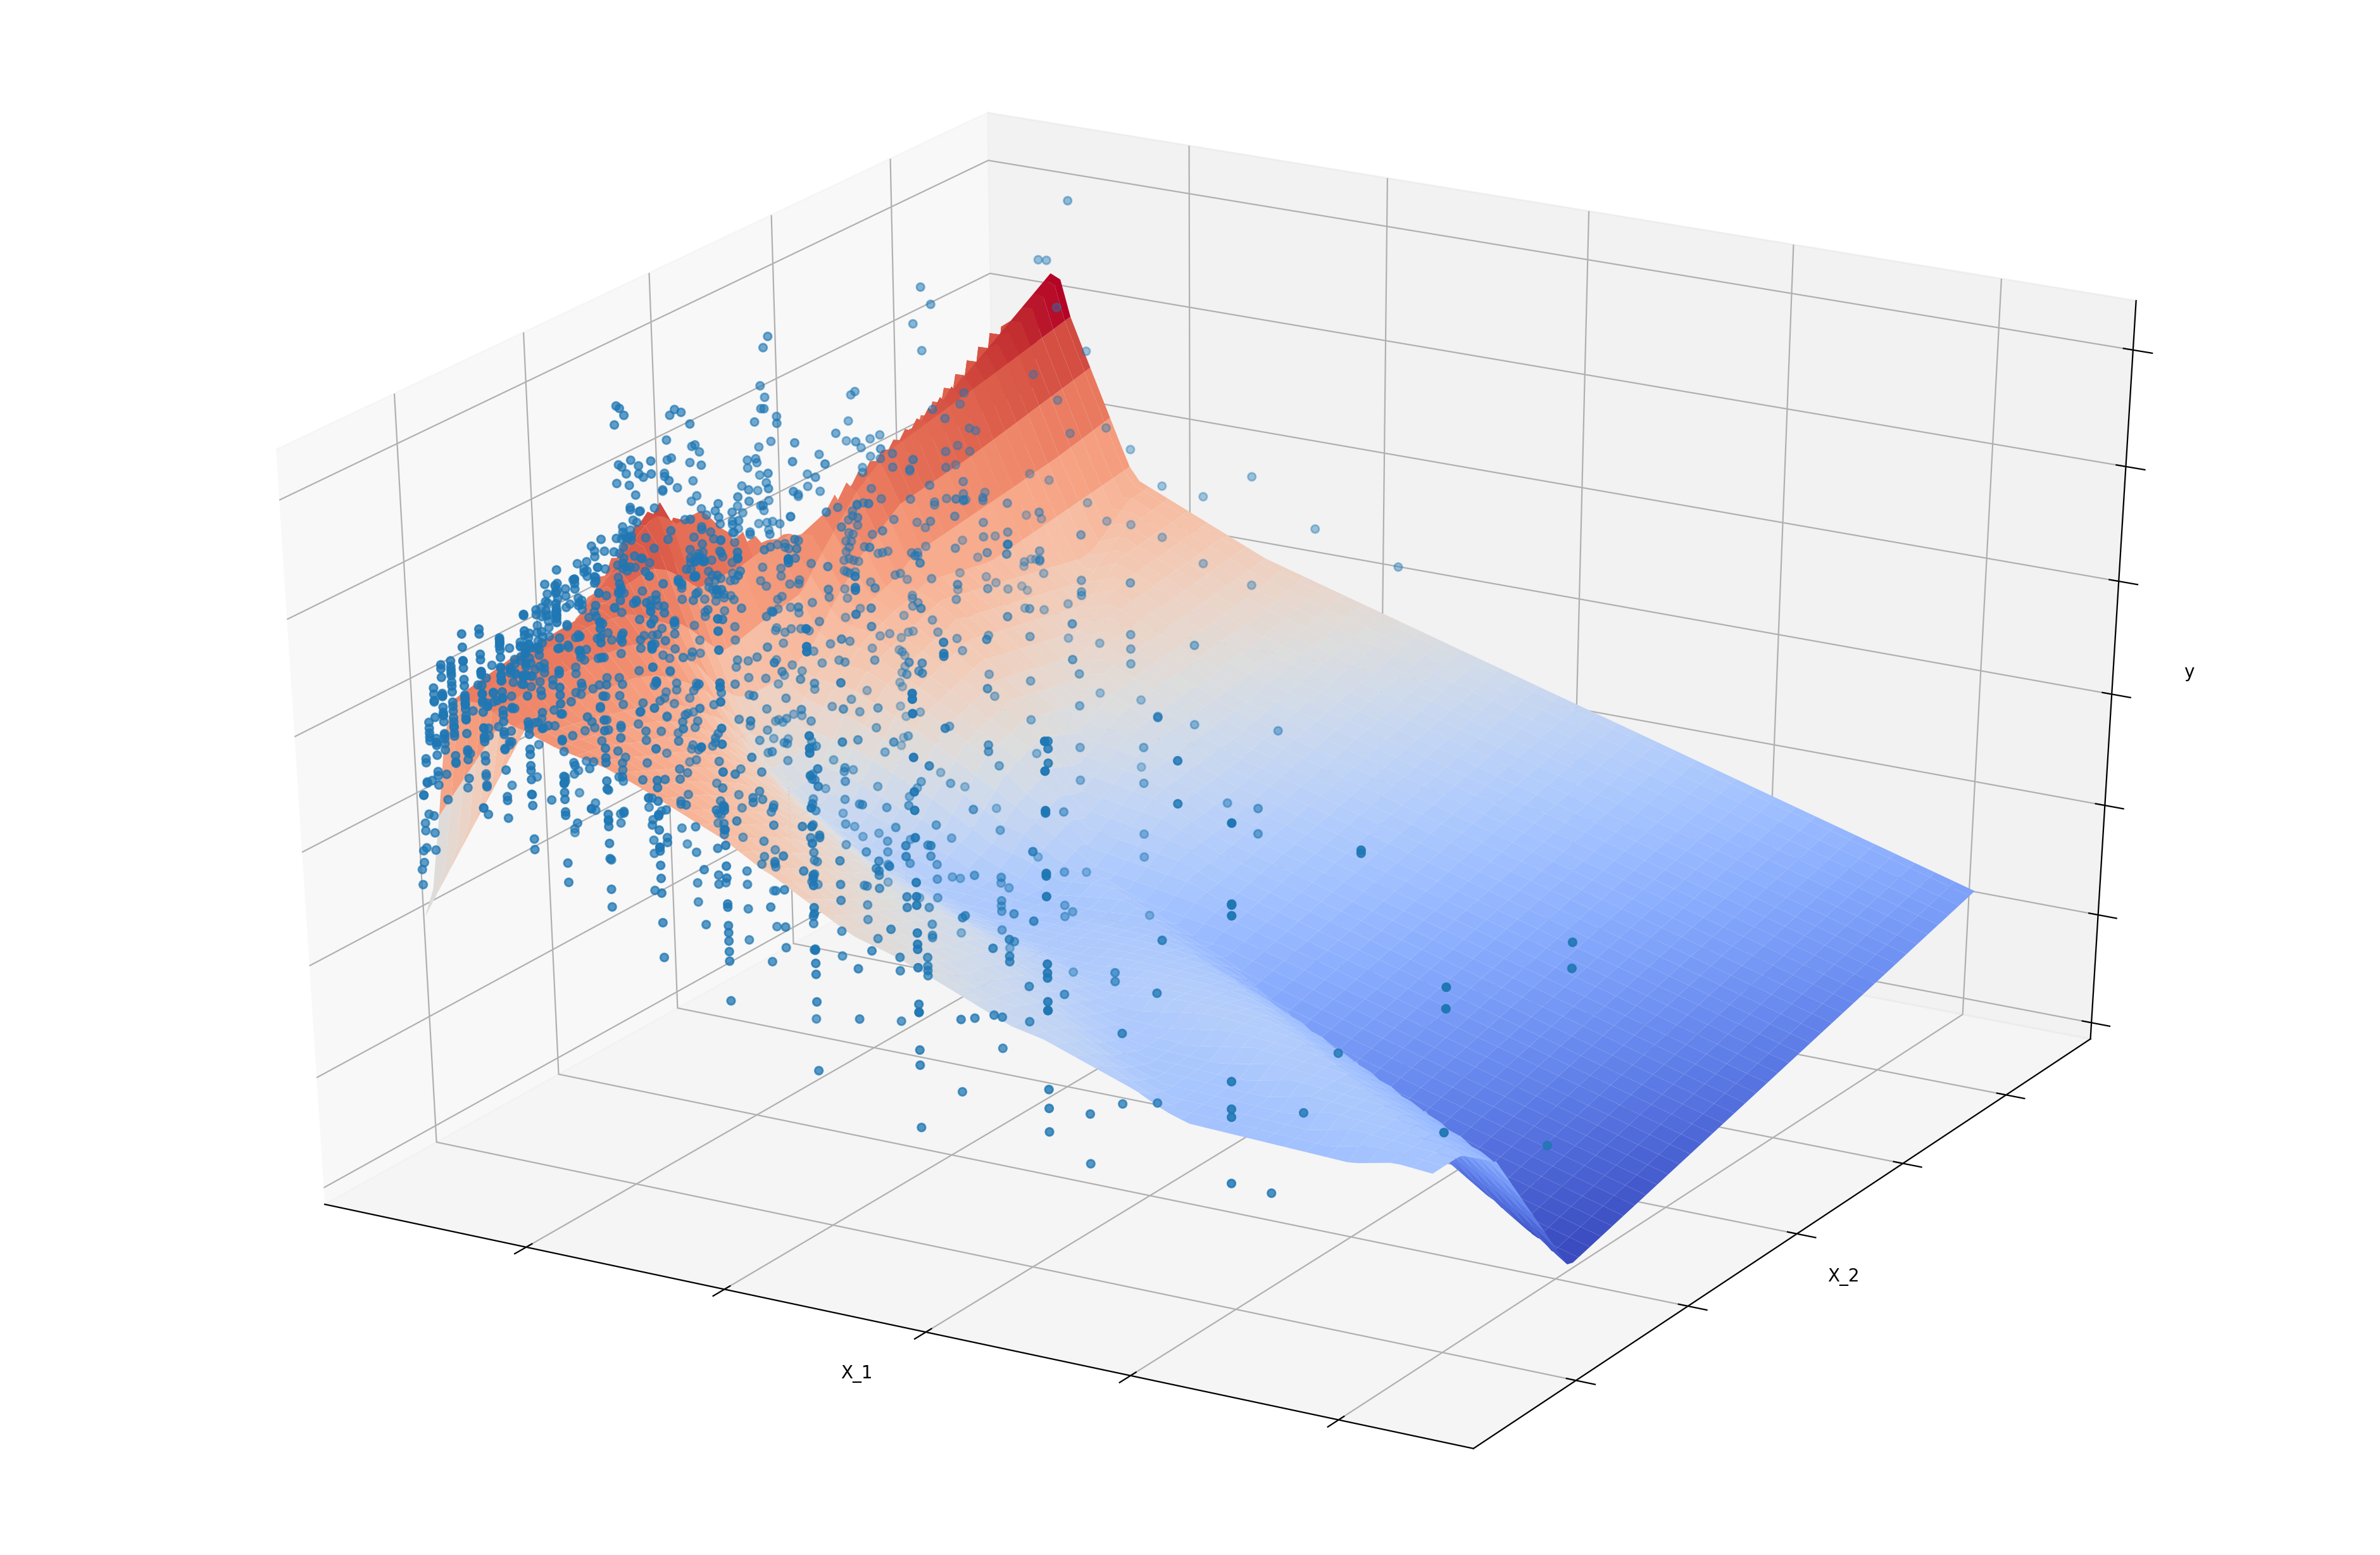

In [10]:
print("DC model on first 2 features")
plotxxy(model, X, y, 'cuda')